In [49]:
import numpy as np
import cv2
import scipy.optimize as opt
import math
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
#np.set_printoptions(precision=None, suppress=True)
np.set_printoptions(suppress=True)


In [50]:
state = pd.read_csv("state.csv")

In [51]:
state

,0
0,MT19937
1,[3122787423 3721310838 1204026599 1952118866 3...
2,23
3,0
4,0.0


In [52]:
arr = np.array(state.iloc[1,0])

In [10]:
arr

array('[3122787423 3721310838 1204026599 1952118866 3323835918 4060200507\n  552735203  476751965  724620709 3538565514 1331808216 4026268235\n 2528324086 1846367101 2989679635 3389372164 2332755575 1991695778\n 1513731169 1528912078  596762433 2166011432 4101919988  457493721\n 1084843444 3836023702 3348519974 3209935254  777996722 2442515456\n  493719164  313272819 1060049429  656710158 1179257121 1138378906\n   49926297 1174818907 2787030037 1237207833 3779185784 2823451280\n 4201715515 1942681989 1099978037 1485354926 2408716778 1088310067\n  863035540 3185622018 2613525622 2513699115  211861821 2602735364\n 1130170447 3402297933 3476250001  630364569 1023164387 4126853388\n 2341940936 4245413334 1779954305 3599302030 2619532385 1171212580\n 2793649452 4199560457 2430205153  194082778 2214269016 1158629392\n  567778160 3215900654  492132419   82402327 2094574472 1280310174\n 2662061330 4266589605 3692248353  778951596 2005779290 2990006072\n 3346984521 3127743087  829674662  394739

In [92]:
rng = np.random.default_rng(3122787423)

In [93]:
#number of matching points
N = 8
n_images = 4
F = np.zeros((n_images,n_images,3,3))
# true_K = np.array([
#     [5,0,2],
#     [0,5,2],
#     [0,0,1]
#     ])
true_K = np.array([
    [800,0,256],
    [0,800,256],
    [0,0,1]
    ])
I = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0]
    ])

In [94]:
def calc_fund_matrix(points1,points2):
    '''
    Takes in 2 arrays of matching points 
    Return Fundamental matrix computes 
    using 8 point algorithm
    '''
#     F, mask = cv2.findFundamentalMat(points1,points2,cv2.FM_8POINT)
    F, mask = cv2.findFundamentalMat(points1,points2)

    return F 

In [95]:
def normalize_coordinates(p):
    # Normalization matrix
    T_m = normalization_matrix(p)
    # Normalized points
    p_norm = (T_m@(p.T)).T
    return p_norm, T_m

    
def manual_find_F_matrix(xy1,xy2):
    # Input: xy1 , xy2 - 2d array of points: row per point [x,y]
    # xy1 - for image 1, xy2 - for image 2
    # FM compute fundametal matrix from point correspondence
    #    at least 8 points are needed
    
    n_points = xy1.shape[0]
    if n_points < 8:
        print('8 points at least are needed')
    
    #add 3rd coordinate '1'
    xy1 = projectivation(xy1)
    xy2 = projectivation(xy2)
    
    
    #normalize coordinates
    xy1_norm, T1 = normalize_coordinates(xy1)
    xy2_norm, T2 = normalize_coordinates(xy2)
    
    # Preparing the equation matrix
    M = np.zeros((n_points,9))
    M[:,0] = xy1_norm[:,0]*xy2_norm[:,0] # x1 * x2
    M[:,1] = xy1_norm[:,0]*xy2_norm[:,1] # x1 * y2 
    M[:,2] = xy1_norm[:,0] # x1
    M[:,3] = xy1_norm[:,1]*xy2_norm[:,0] # y1 * x2
    M[:,4] = xy1_norm[:,1]*xy2_norm[:,1] # y1 * y2
    M[:,5] = xy1_norm[:,1] # y1
    M[:,6] = xy2_norm[:,0] # x2
    M[:,7] = xy2_norm[:,1] # y2
    M[:,8] = 1

    # calc M^T * M to get symmetruc square matrix
    W = M.T@M
    
    # desompose W into U (singular values), D (diagonal matrix), Vt (singular vectors)
    U,D,Vt = np.linalg.svd(W,compute_uv=True)
    a = U[:,-1]     # solution vector corresponding to the 
                    # least singular value
    A = np.reshape(a.T,(3,3))

    # Returning to non-normalized points
    F = np.linalg.inv(T2)@A@T1

    return F

In [96]:
### function used in class
def projectivation(p):
    '''
    Input: p, Nxd matrix = N points in R^d
    Output: q, Nx(d+1) = N points in P^d
    '''
    N,d = p.shape
    q = np.ones((N,d+1))
    q[:,0:d] = p 
    return q 

def affinization(q):
    '''
    Input: q, Nx(d+1) = N points in P^d
    Output: p, Nxd matrix = N points in R^d
    '''
    N,d1 = q.shape
    d = d1-1
    p = np.ones((N,d))
    p = q[:,0:d]/q[:,d:d+1] 
    
    return p

def normalization_matrix(p):
    '''
    Input: p: Nx2 matrix
    Output: T, normalization matrix (in projective plane) 
    '''

    # Computation
    m = np.mean(p,axis=0)
    q = p - np.repeat(m[np.newaxis,:],N,axis=0)
    w = np.sqrt(np.sum(q**2,axis=1))
    scale = 1/np.mean(w)

    # Normalization matrix
    T = np.zeros((3,3))
    T[2,2] = 1
    T[0,0] = scale
    T[0,2] = -m[0]*scale
    T[1,1] = scale
    T[1,2] = -m[1]*scale
        
    return T

In [97]:
def mendonca_cost_func(X):
    '''
    computes Mendonca & Cipolla Cost function to find the Optimal Intrinsic Parameters
    Input
    X      - Approximate Values of Intrinsics - 1D array with length 5
    Output
    E    - Computed Cost
    '''

    #Transform Intrinsics to Matrix Form
#     K = np.array([
#         [X[0],X[1],X[2]],
#         [0,X[3],X[4]],
#         [0,0,1]
#     ])
    K = np.array([
        [X[0],0,X[1]],
        [0,X[2],X[3]],
        [0,0,1]
    ])
    #Initialize Cost
    E = 0
    '''
       F - globally defined Fundamental Matrix between given two Images (F[i,j,3x3])
    '''
    # For the Denominator term of Mendonca & Cipolla's Equation
#     nof_images = len(F[0]) #number of images given
    nof_images = numberOfViews
    Den = nof_images*(nof_images-1)/2 # For N Images there are N(N-1)/2 Fundamental Matrices
  # 0 1 2 3 [0-1, 0-2,0-3, 1-2,1-3,2-3]
    # i  j
    # 0 -1 
    # 0 -2
    # 0 -3
    # 1- 2
    # 1 -3
    # 2 -3
  # len =4

    #Compute the Cost using Mendonca & Cipolla's Equation
    for i in range(0,nof_images-1):
        for j in range (i+1,nof_images):

            # Compute the Essential Matrix 'EM' from Fundamental of images i,j
#             EM = K.T @ F[i,j,:,:] @ K
            EM = K.T @ Fs[:,:,i,j] @ K

            # Compute SVD of Essential Matrix
            _,D,_ = np.linalg.svd(EM)
             # Singular Values (3rd value, D[3] is 0 according to theorem)
            r = D[0]
            s = D[1]
            
            #  Compute Cost

            E+= (1/Den) * (r - s)/s

    return E


In [98]:
def p3t(T,x,y,z):
    # apply a Projective 3D Transform
#     print(x.shape)
    xyz = np.concatenate((x, y, z),axis=1)
#     print(xyz)
#     print("np.concatenate((xyz,column_ones),axis=1)")
    column_ones = np.ones((len(x),1))
#     print(np.concatenate((xyz,column_ones),axis=1))
    tmp = T @ (np.concatenate((xyz,column_ones),axis=1)).T
    xp = (tmp[0,:]/tmp[3,:]).T
    yp = (tmp[1,:]/tmp[3,:]).T
    zp = (tmp[2,:]/tmp[3,:]).T
    return xp,yp,zp

In [99]:
def projf(P,x,y,z):
#     % PROJ  compute perspective projection (from 3D to pixel coordinates)
#     %   pixel positions are returned with floating point precision
#     %
#     %   See also PROJE
    print("P\n",P.shape)
    c3d = np.concatenate((x, y, z),axis=1)
    print("c3d\n",c3d.shape)
    column_ones = np.ones((len(x),1))
    h3d = (np.concatenate((c3d,column_ones),axis=1)).T
    print("h3d\n",h3d.shape)
    h2d = P @ h3d
    print("h2d.shape\n",h2d.shape)
#     print("h2d\n",h2d)

    c2d = h2d/ h2d[2,:]

    u = c2d[0,:].T
    v = c2d[1,:].T
    return u,v

In [100]:
def plot_3d(x,y,z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    plt.show()

In [101]:
def plot_2d(x,y):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    plt.show()

In [102]:
def conver_to_col(x):
    return np.reshape(x,(len(x),1))

In [103]:
def rcam(A):
# RCAM generate a random camera
#    generate a random camera pointing to lookp, positioned at an average 
#    distance ad form the origin, with a std dev of sd 
#    A is the intrinsic parameters matrix

    ad=2.5
    sd=0.25
    lookp=np.zeros((1,3))
    eyep = rng.uniform(-1,1,size=(1,3))-0.5
    R = np.zeros((3,3))
    eyep = eyep/np.linalg.norm(eyep) * (ad + sd*rng.random(1))
#     print(eyep)
    R[2,:] = lookp - eyep/np.linalg.norm(lookp - eyep)
    R[1,:] = np.cross(R[2,:],rng.uniform(size=(1,3)))
    R[1,:] = R[1,:]/np.linalg.norm(R[1,:])
    R[0,:] = np.cross(R[1,:],R[2,:])
    Rt = np.concatenate((R,-R @ eyep.T),axis=1)
#     print(np.matrix(Rt))
    return A @ Rt


In [104]:
numberOfViews=5
numberOfPoints = 50
imagePoints = np.zeros((numberOfPoints,2,numberOfViews))
PPM = np.zeros((3,4,numberOfViews))
PPMGT = np.zeros((3,4,numberOfViews))

In [105]:
Fs = np.zeros((3,3,numberOfViews,numberOfViews))

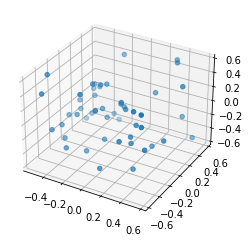

matrix P
 [[ 125.99543216  208.81280038  803.7775597   653.22200205]
 [-393.51886319  740.44862864  -49.13992929  653.22200205]
 [  -0.87398198   -0.0870208     0.47810341    2.55164845]]
invAP
 [[ 0.43716853  0.28886266  0.85172886  0.        ]
 [-0.21222434  0.95340744 -0.214418    0.        ]
 [-0.87398198 -0.0870208   0.47810341  2.55164845]]
lower_line
 [[0, 0, 0, 1]]
G0
 [[ 0.43716853  0.28886266  0.85172886  0.        ]
 [-0.21222434  0.95340744 -0.214418    0.        ]
 [-0.87398198 -0.0870208   0.47810341  2.55164845]
 [ 0.          0.          0.          1.        ]]


In [106]:
### test same as italian
data = (rng.uniform(size=(numberOfPoints,3),)-0.5)/(math.sqrt(3)/2)
x = data[:,0]
y = data[:,1]
z = data[:,2]
xr = np.reshape(x,(len(x),1))
yr = np.reshape(y,(len(y),1))
zr = np.reshape(z,(len(z),1))

plot_3d(x,y,z)
A = true_K
P = rcam(A)
print("matrix P\n",np.matrix(P))
invAP = np.linalg.inv(A) @ P
print("invAP\n",invAP)
lower_line = [[0,0,0,1]]
print("lower_line\n",lower_line)
G0 = np.concatenate((invAP, lower_line),axis=0)
print("G0\n",np.matrix(G0))


In [107]:
x,y,z = p3t(G0,xr,yr,zr)
P = A @ np.concatenate((np.identity(3), np.zeros((3,1))),axis=1)
# print("P\n",P)
# print(x)
# print(conver_to_col(x))
u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

imagePoints[:,0,0] = u
imagePoints[:,1,0] = v
PPMGT[:,:,0] = P

print("u\n",u)
print("v\n",v)

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)
u
 [111.58224779 209.54990699 287.75704535 304.6977166  184.41724716
 134.7273839  491.87041931 233.47175542 312.75002941 498.87436366
 319.34758864 256.58909328 140.99838291 374.32708289 307.43282366
 245.59911153 400.03214881 311.2066683  297.95709019 147.13395873
 308.19318578 306.77678762  87.90160451 228.42740639  98.81985388
 151.53519832 378.98046835 292.85158418 260.9491565  294.08289263
 139.97902864 371.64376995 440.98466729 193.38835685 206.33354556
 236.46495712 148.76860036 134.98598263 102.72090553 333.73792642
 185.82777347  87.18490806 232.47720087 135.33373313 205.53217946
 106.45305954 501.86130975 262.29428753 274.25949777 325.74543982]
v
 [474.61022454 355.99710595 259.24200232 158.89154361 242.47974538
 231.74521555 373.16580271 373.25970107 130.34619705 344.48172156
 188.59308133  84.33631579 368.18292125  41.04542165 101.85078616
 443.02571113  58.22699555 245.99192108 247.6944261  283.02880104
 159.28694644 

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


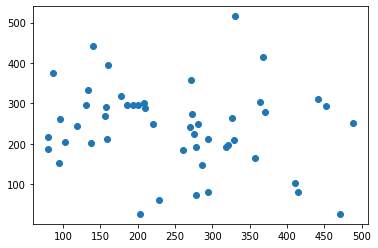

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


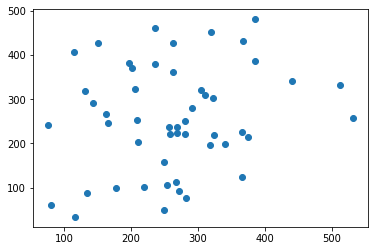

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


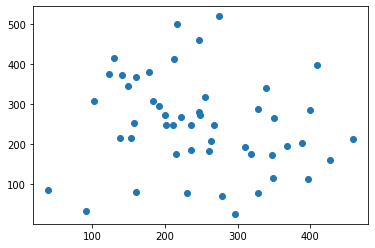

P
 (3, 4)
c3d
 (50, 3)
h3d
 (4, 50)
h2d.shape
 (3, 50)


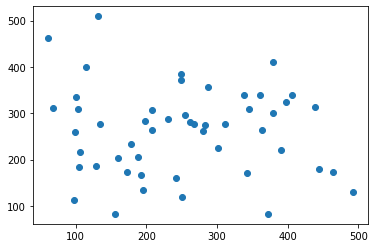

In [108]:
for view in range (1,numberOfViews):

    #   % random camera position
    P = rcam(A)

    #   % apply world coordinate transformation
    P = P @ np.linalg.inv(G0);

    #   % project world points to image points
    u,v = projf(P,conver_to_col(x),conver_to_col(y),conver_to_col(z))

    #   % add noise to image points
    #       u = u + sigma * randn(size(u));
    #       v = v + sigma * randn(size(v));

    imagePoints[:,0,view] = u
    imagePoints[:,1,view] = v

    PPMGT[:,:,view] = P   
    plot_2d(u,v)

In [109]:

for i in range(numberOfViews):
    for j in range(i+1,numberOfViews):
        Fs[:,:,i,j] = calc_fund_matrix(imagePoints[:,:,i],imagePoints[:,:,j])

In [110]:
initial_K =  [true_K[0,0], true_K[0,2],true_K[1,1],true_K[1,2]]
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

In [111]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],0,res.x[1]],[0,res.x[2],res.x[3]],[0,0,1]])
print (np.matrix(result_K))

[[799.98911309   0.         255.99920977]
 [  0.         799.98828015 255.99955479]
 [  0.           0.           1.        ]]


In [124]:
initial_K = [1,200,1,1]
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],0,res.x[1]],[0,res.x[2],res.x[3]],[0,0,1]])
print (np.matrix(result_K))

[[ 100966.57497141       0.         -273208.24876514]
 [      0.          280794.97424055   -6312.28821548]
 [      0.               0.               1.        ]]


In [112]:
print(data)

[[-0.2761682   0.52293841 -0.56107746]
 [-0.39585619  0.26566492 -0.08025784]
 [ 0.01546076  0.0368919   0.0999238 ]
 [ 0.30832208 -0.21106542  0.0804977 ]
 [-0.34558681 -0.14321857 -0.07155691]
 [-0.45294592 -0.23684723 -0.19856033]
 [ 0.31412258  0.56215667  0.50261992]
 [-0.4456677   0.35210157  0.0129011 ]
 [-0.14484451 -0.4123722   0.45850769]
 [ 0.35773499  0.48188061  0.52566502]
 [ 0.16410209 -0.14131452  0.1975107 ]
 [ 0.27783959 -0.46489102  0.01709802]
 [-0.4128456   0.2361272  -0.32966725]
 [ 0.49884607 -0.4694186   0.3027931 ]
 [ 0.0400381  -0.4639814   0.34216901]
 [ 0.54139275  0.46212483 -0.46234937]
 [ 0.4074025  -0.44222162  0.45955645]
 [-0.17439902 -0.00381918  0.3224133 ]
 [-0.25048404 -0.01690607  0.3142434 ]
 [-0.49030322 -0.05014896 -0.19340405]
 [ 0.5554711  -0.15265551 -0.07686542]
 [-0.17441391  0.10984353  0.26241431]
 [-0.17398027 -0.26821862 -0.44054025]
 [ 0.28446863 -0.25880292 -0.14945054]
 [-0.28561403 -0.43800359 -0.32409431]
 [-0.48834169  0.15767055

In [113]:
print(PPMGT)

[[[ 800.          826.04554014  682.81560249  -50.66851276  269.47237951]
  [   0.          126.68693714 -182.18618075 -152.51049175  781.62129629]
  [ 256.          -84.4700277   453.99014145 -824.44481424 -148.28616206]
  [   0.          894.07921574 -498.1679318  2767.52178073 1029.61659818]]

 [[   0.          -69.1898455   249.14501236   18.95834103  667.01095761]
  [ 800.          796.29264732 -637.90272659  807.6208903   -49.71921052]
  [ 256.         -258.19911909 -486.35673556 -230.0545128   508.09485584]
  [   0.         1337.3747817  1901.26671514 1250.84669205 -645.23700577]]

 [[   0.            0.29609098    0.79991355    0.89849817    0.81640213]
  [   0.            0.5906212     0.30510586    0.18211222   -0.06284639]
  [   1.            0.75066419   -0.51676757   -0.39941981   -0.57405391]
  [   0.            0.73512123    3.89773146    3.61225883    4.00869957]]]


In [114]:
print(G0)

[[ 0.43716853  0.28886266  0.85172886  0.        ]
 [-0.21222434  0.95340744 -0.214418    0.        ]
 [-0.87398198 -0.0870208   0.47810341  2.55164845]
 [ 0.          0.          0.          1.        ]]


In [115]:
import pandas as pd

In [82]:
points = pd.DataFrame(data)
points.to_csv('points.csv', index=False)  

In [86]:
df_state  = pd.DataFrame(state)
df_state.to_csv('state.csv',index=False)

In [ ]:
eyep = rng.random.uniform(size=(1,3))-0.5
print(eyep)

In [ ]:
def randomize_rt():
    angle = rng.random.uniform(0,45)
    cos =  math.cos(angle)
    sin =  math.sin(angle)
#     t = rng.random.randint(-5,5,(3,1))
    t = np.zeros((3,1))
    t[2] = 1
    t = np.zeros((3,1))
    R = np.array([[cos,-sin,0],[sin,cos,0],[0,0,1]])
    Rt = np.concatenate((R,t),axis=1)
    print(Rt)
    low_row = np.zeros((1,4))
    low_row[:,-1] = 1
    Rt = np.concatenate((Rt,low_row),axis=0)
#     lowes_row = np.array([0,0,0,1])
#     Rt = np.concatenate((Rt,lowes_row),axis=0)
    print (np.matrix(Rt))
    return Rt

In [ ]:
rt = randomize_rt()


In [ ]:
def randomize_3d_points(num_of_points):
    world_points = rng.random.uniform(-1,1,(num_of_points,3))
    return world_points

def get_projection_of_points(world_points):
    world_points_hom = projectivation(world_points)
    return world_points_hom

In [ ]:
world_points = randomize_3d_points(N)
T1 = normalization_matrix(world_points)
world_points_hom = get_projection_of_points(world_points)

In [ ]:
world_points_hom.shape

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [ ]:
(world_points_hom[0])

In [ ]:
image0_p0 = np.zeros(3)
rt = randomize_rt()
k_extended = np.concatenate((true_K,np.zeros(shape=(3,1))),axis=1)
print(k_extended)
image0_p0 = k_extended @ world_points_hom[0]

In [ ]:
image0 = np.zeros((N,3))
for i in range(N):
    image0[i,:] = true_K @ I @ world_points_hom[i]
    image0[i,:] = image0[i,:]/image0[i,-1]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(image0[:,0],image0[:,1])
plt.show()

In [ ]:
projected = np.zeros((n_images,N,3))

for image in range(n_images):
    if (image == 0): # use the first image as it was not rotated
#         rt = I
        rt = np.identity(4)
    else:
        rt = randomize_rt()
    print (np.matrix(rt))
    for point in range(N):
#         projected[image,point,:] = true_K @ rt @ world_points_hom[point]
        projected[image,point,:] = k_extended @ rt @ world_points_hom[point]
        projected[image,point,:]/= world_points[point,-1]


In [ ]:
print(projected)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,20))

for i, ax in enumerate(axes.ravel()):
    ax.scatter(projected[i,:,0],projected[i,:,1], alpha=.5)
    ax.grid()
    
plt.tight_layout()

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(projected[i,:,0:2],projected[j,:,0:2])

In [ ]:
np.matrix(F[0,1])

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        print(i,j)
        print(np.matrix(F[i,j]))

In [ ]:
initial_K =  rng.random.randint(-5,5,(5))
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')
# res = opt.minimize(mendonca_cost_func,x0=initial_K)

In [ ]:
res

In [ ]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

In [ ]:
print(np.matrix(true_K))

In [ ]:
image0_p0/image0_p0[2]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(world_points[:,0],world_points[:,1],world_points[:,2])
plt.show()

In [ ]:
# EXPERIMENT

# array of n_images with original coordinates of N points (x,y)
p = np.zeros((n_images,N,2))
# array of n_images with projective coordinats of M points (x,y,1)
pj = np.zeros((n_images,N,3))

# randomly initialize 1st image (index #0)
p[0] = rng.random.randint(0,500,(N,2))
pj[0] = projectivation(p[0])

#init random matrices to transform original image
A = rng.random.randint(-6,6,(n_images-1,3,3))
A[:,] = np.triu(A[:,])
# transform original image to get new images 
for i in range(1,n_images):
    pj[i] = (A[i-1]@pj[0].T).T
    p[i] = affinization(pj[i])
   
# insert noise
noise_level1 = 0.25
for i in range(n_images):
    p[i] += noise_level1*rng.random.randn(N,2)

In [ ]:
print (A[0])

In [ ]:
print (p.shape)

In [ ]:
for i in range(n_images-1):
    for j in range(i+1,n_images):
        F[i,j] = calc_fund_matrix(p[i],p[j])

In [ ]:
initial_K =  rng.random.randint(-5,5,(5))

In [ ]:
res = opt.minimize(mendonca_cost_func,x0=initial_K, method='Nelder-Mead')

In [ ]:
print (res)

In [ ]:
result_K = np.zeros((3,3))
result_K = np.array([[res.x[0],res.x[1],res.x[2]],[0,res.x[3],res.x[4]],[0,0,1]])
print (np.matrix(result_K))

In [ ]:
#reconststruction

#find Fundamental matrix
F12 = np.zeros((3,3))
F12 = calc_fund_matrix(p[0],p[1])

#find Essential matrix
EM = result_K.T @ F @ result_K

#factorize EM to find R,t
U,D,Vt = np.linalg.svd(EM)

In [ ]:
randomize_rt()